In [1]:
import gymnasium as gym
from gym.wrappers import record_video

import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os

video_path = os.path.join(os.getcwd(), '..', 'recordings', 'dqn')
print(video_path)

def record_ep(ep: int) -> bool: return not(ep % 100)

env = gym.make("ALE/MontezumaRevenge-v5", obs_type="grayscale", render_mode='rgb_array')
env = record_video.RecordVideo(env, video_path, episode_trigger=record_ep, name_prefix="montezumarevenge_dqn")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\PedroJardim\Documents\OneDrive\Thesis\src\..\recordings\dqn


e:\Anaconda\envs\Masters310\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(
e:\Anaconda\envs\Masters310\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\PedroJardim\Documents\OneDrive\Thesis\recordings\dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_actions):
        super(DQN, self).__init__()

        # initialize sets CONV => RELU => POOL layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=(5, 5))
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize sets of FC
        self.fc1 = nn.Linear(in_features=10878, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=n_actions)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        #print(f'First conv1 and pool: {x.size()}')
        x = self.maxpool(F.relu(self.conv2(x)))
        #print(f'Second conv1 and pool: {x.size()}')
        x = torch.flatten(x, 1)
        #print(f'After flatten: {x.size()}')
        x = F.relu(self.fc1(x))
        #print(f'After first layer: {x.size()}')
        x = F.log_softmax(self.fc2(x), dim=1)

        #print(f'Return: {x.size()}')
        #print(f'{x}')

        return x

In [4]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
MEM_SIZE = 10000

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_pixels = gym.spaces.flatdim(env.observation_space)

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEM_SIZE)

steps_done = 0

e:\Anaconda\envs\Masters310\lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [5]:
def select_action(state: torch.Tensor) -> torch.Tensor:
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    action = None

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            values, indexes = torch.max(policy_net(state.unsqueeze(0)), dim=1)
            # quite complicated. Basically find max value from each row, and then the max of it. 
            # Then retrieve its index, which is the action
            return torch.tensor([[indexes[((values == torch.max(values)).nonzero(as_tuple=True)[0]).item()].item()]], device=device, dtype=torch.long)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # requires shape of itself because some states are None
    non_final_next_states = non_final_next_states.unsqueeze(0).reshape((len(non_final_next_states), 1, 210, 160))

    state_batch = torch.cat(batch.state, 0).unsqueeze(0).reshape((BATCH_SIZE, 1, 210, 160))
    action_batch = torch.cat(batch.action, 0)
    reward_batch = torch.cat(batch.reward, 0)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        #print(non_final_next_states.size())
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


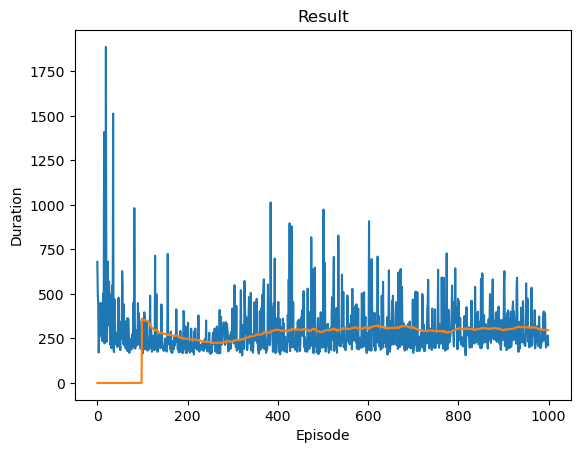

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
num_episodes = 50000

rewards = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    
    # unsqueeze turns tensor from size [210, 160] to [1, 210, 160]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    ep_reward = 0

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # record rewards
        ep_reward += reward

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

    rewards.append(ep_reward)

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [8]:
max(rewards)

0.0

In [9]:
np.mean(episode_durations)

294.519